In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.display import show2D
from cil.plugins.astra import ProjectionOperator
from cil.plugins.astra.processors import FBP

In [ ]:
def create_grid(shape = (256, 64, 256)):
    # Create a circular grid phantom in a volume with shape (X, Y, Z)
    shape = (256, 64, 256)    
    volume = np.zeros(shape, dtype=np.float32)

    margin = 16
    center_x, center_z = shape[0] // 2, shape[2] // 2
    radius = min(center_x, center_z) - margin
    edge_thickness = 1

    z_vals = np.arange(margin, shape[0] - margin)
    x_vals = np.arange(margin, shape[2] - margin)
    zz, xx = np.meshgrid(z_vals, x_vals, indexing='ij')  

    r2 = (xx - center_x)**2 + (zz - center_z)**2
    cylinder_mask = r2 <= radius**2
    cylinder_edge_mask = (r2 >= (radius - edge_thickness)**2) & (r2 <= (radius + edge_thickness)**2)

    grid_spacing = 16

    for zi, z in enumerate(z_vals):
        for xi, x in enumerate(x_vals):
            if not cylinder_mask[zi, xi]:
                continue
            if (x % grid_spacing == 0) or (z % grid_spacing == 0):
                volume[z, margin:shape[1] - margin, x] = 1.0


    # Apply edge mask in XZ plane across Y
    for yi in range(margin, shape[1] - margin):
        for zi, z in enumerate(z_vals):
            for xi, x in enumerate(x_vals):
                if cylinder_edge_mask[zi, xi]:
                    volume[z, yi, x] = 1.0



    ig = ImageGeometry(voxel_num_x=shape[0], voxel_num_y=shape[1], voxel_num_z=shape[2])
    grid = ImageData(volume, geometry=ig)

    return grid, ig


We start by simulating a flat circular mesh grid in a 3D volume

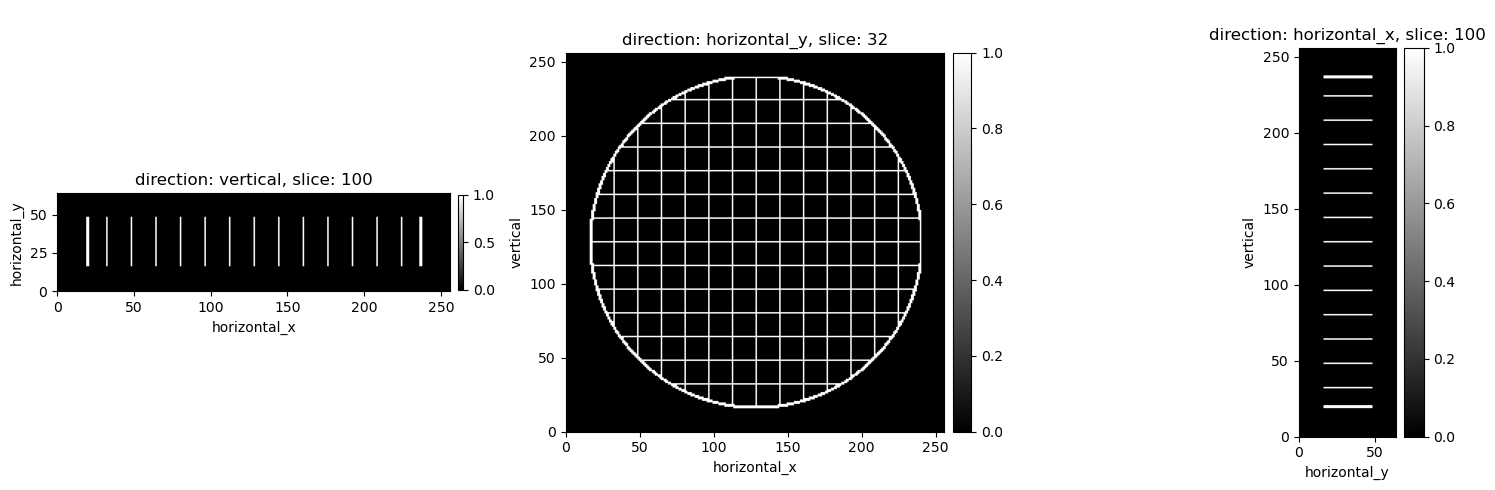

In [ ]:
# call the create_grid function to get a grid and its image geometry
grid, ig = create_grid()

# then show what the volume looks like from 3 different axes
ax = show2D(grid,
       slice_list=[
           (0, 100),  
           (1, grid.shape[1]//2),  
           (2, 100),
       ],
       num_cols=3,
       size=(15,5))


We simulate the projections which would be generated by the grid in a parallel beam CT geometry setup

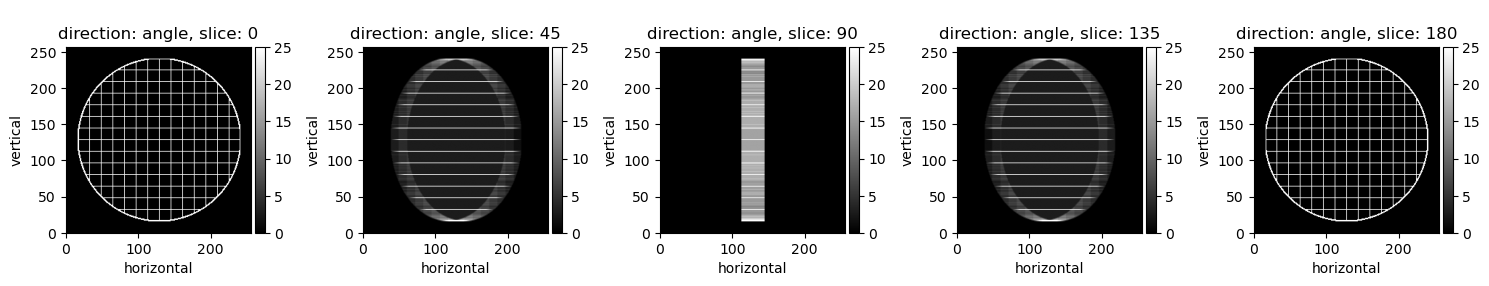

In [180]:
# first we create an acquisition geometry which will describe the projection data
ag = AcquisitionGeometry.create_Parallel3D()\
    .set_angles(np.arange(0,360))\
    .set_panel([256, 256])
ag.dimension_labels = ('vertical', 'angle','horizontal')

# then we use a projection operator to simulate the projections
A = ProjectionOperator(ig, ag)
proj = A.direct(grid)
ag_slice_list = [('angle', 0),('angle',45), ('angle',90), ('angle',135), ('angle',180)]
show2D(proj,
       slice_list = ag_slice_list, 
       num_cols=5,
       fix_range=(0,25))

Notice that the projections have quite different levels of intensity at different projections as we look through the long and short plane of the sample.
Let's see what it looks like if we try to reconstruct the grid from these projections.

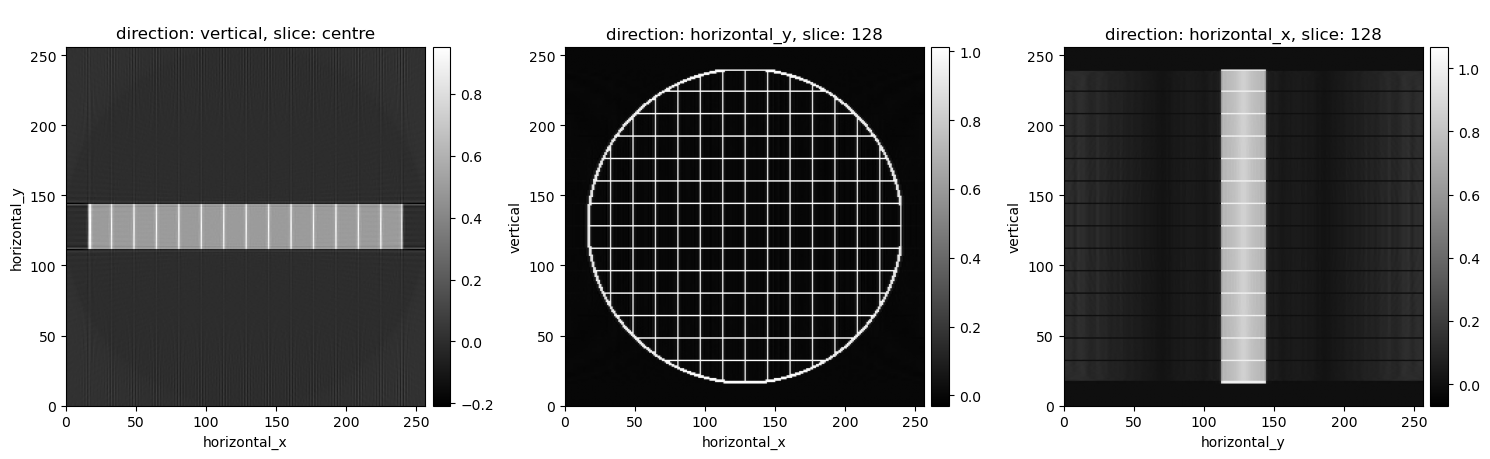

In [ ]:
# Run the reconstruction
FBP_recon = FBP(image_geometry=None, acquisition_geometry=ag)(proj)

slice_list = [('vertical','centre'), ('horizontal_y',int(FBP_recon.shape[2]/2)), ('horizontal_x',int(FBP_recon.shape[1]/2))]
show2D(FBP_recon,
       slice_list=slice_list,
       num_cols=3)

In [ ]:
plt.plot(FBP_recon.array[128, :, 128])

We notice some strange artefacts in the reconstruction. This is because of the un-even absorption we noticed in the projections.

A common solution to these kind of artefacts is to tilt the sample and rotation axis to give a more uniform absorption profile, this setup is called laminography. We can simulate the laminography setup by projecting the original grid volume with a tilted rotation axis

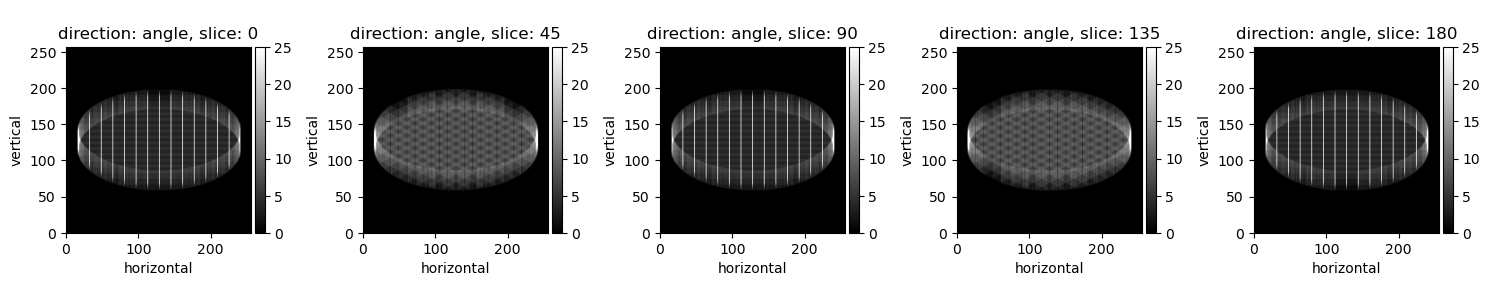

In [188]:
# first rotate the grid volume onto the z-y plane
grid_tilt = np.rot90(grid.array, k=1, axes=(0, 1))
ig = ImageGeometry(voxel_num_x=grid_tilt.shape[2], voxel_num_y=grid_tilt.shape[1], voxel_num_z=grid_tilt.shape[0])
grid_tilt = ImageData(grid_tilt, geometry=ig)

# next we define a tilt angle along the x-axis
tilt = 30 # degrees
tilt_rad = np.deg2rad(tilt)
tilt_direction = np.array([1, 0, 0])
beam_direction = np.array([0, 1, 0])
untilted_rotation_axis = np.array([0, 0, 1])
rotation_matrix = Rotation.from_rotvec(tilt_rad * tilt_direction)
tilted_rotation_axis = rotation_matrix.apply(untilted_rotation_axis)

# we recreate the acquisition geometry with a tilted axis
ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_direction=tilted_rotation_axis)\
    .set_angles(np.arange(0,360))\
    .set_panel([256, 256])
ag.dimension_labels = ('vertical', 'angle','horizontal')

# then we use a projection operator to simulate the projections
A = ProjectionOperator(ig, ag)
proj = A.direct(grid_tilt)
ag_slice_list = [('angle', 0),('angle',45), ('angle',90), ('angle',135), ('angle',180)]
show2D(proj,
       slice_list = ag_slice_list, 
       num_cols=5,
       fix_range=(0,25))

The projections now have very uniform attenuation. Let's try reconstructing this dataset

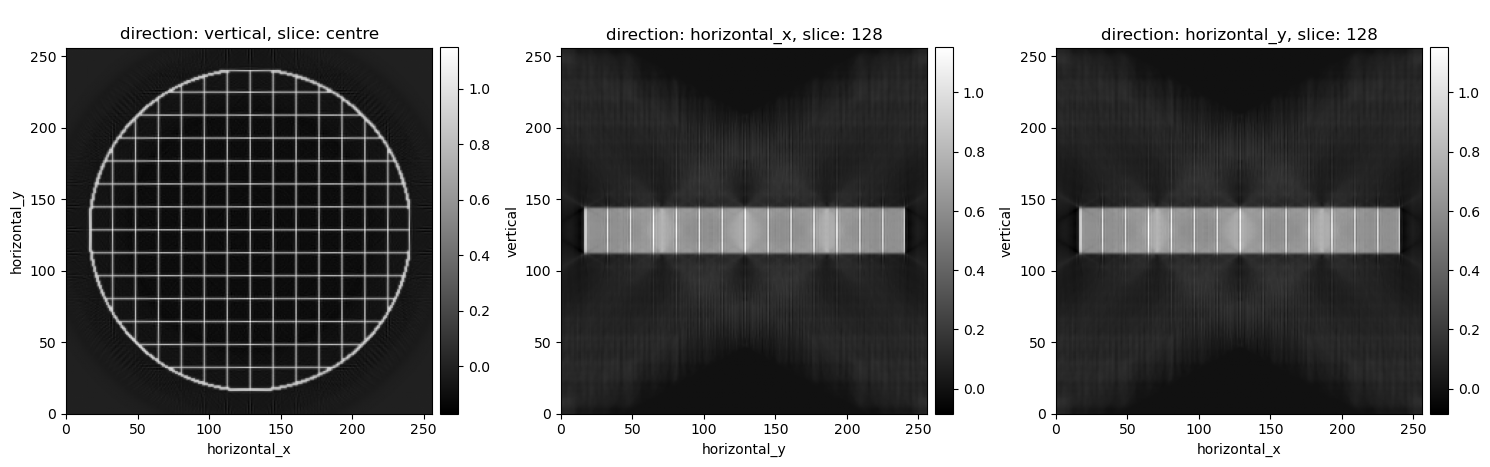

In [189]:
FBP_recon = FBP(image_geometry=None, acquisition_geometry=ag)(proj)

slice_list = [('vertical','centre'), ('horizontal_x',int(FBP_recon.shape[1]/2)), ('horizontal_y',int(FBP_recon.shape[2]/2))]
show2D(FBP_recon,
       slice_list=slice_list,
       num_cols=3)

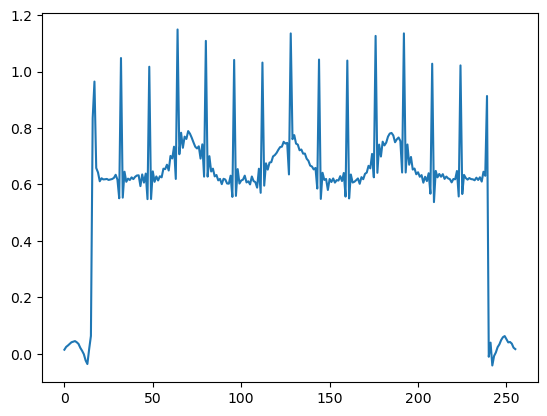

In [190]:
plt.plot(FBP_recon.array[128, :, 128])

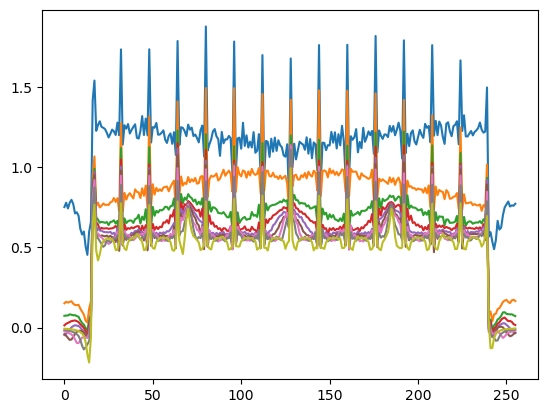

In [191]:
for tilt in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    tilt_rad = np.deg2rad(tilt)

    rotation_matrix = Rotation.from_rotvec(tilt_rad * tilt_direction)
    tilted_rotation_axis = rotation_matrix.apply(untilted_rotation_axis)

    ag.config.system.rotation_axis.direction = tilted_rotation_axis

    A = ProjectionOperator(ig, ag)
    proj = A.direct(grid_tilt)

    FBP_recon = FBP(image_geometry=None, acquisition_geometry=ag)(proj)
    plt.plot(FBP_recon.array[128, :, 128])
#

Utils

In [ ]:
def create_grid(shape = (64, 256, 256)):
    # Create a circular grid phantom in a volume with shape (Z, Y, X)
    
    volume = np.zeros(shape, dtype=np.float32)

    margin = 16
    center_x, center_y = shape[2] // 2, shape[1] // 2
    radius = min(center_x, center_y) - margin
    edge_thickness = 1
    yy, xx = np.meshgrid(np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    r2 = (xx - center_x)**2 + (yy - center_y)**2
    cylinder_mask = r2 <= radius**2
    cylinder_edge_mask = (r2 >= (radius - edge_thickness)**2) & (r2 <= (radius + edge_thickness)**2)

    grid_spacing = 16

    x_range = range(margin, shape[2] - margin)
    y_range = range(margin, shape[1] - margin)

    for y in y_range:
        for x in x_range:
            if not cylinder_mask[y, x]:
                continue
            if (x % grid_spacing == 0) or (y % grid_spacing == 0):
                volume[margin:shape[0]-margin, y, x] = 1.0 

    for z in range(margin, shape[0] - margin):
        volume[z][cylinder_edge_mask] = 1  

    ig = ImageGeometry(voxel_num_x=shape[2], voxel_num_y=shape[1], voxel_num_z=shape[0])
    lines = ImageData(volume, geometry=ig)

    return lines, ig